Importing required libraries

In [4]:
import pandas as pd
import numpy as np
from scipy.signal import spectrogram
import pywt
import ast
import wfdb

In [5]:
ptbxl_database_path = 'ptbxl/ptbxl_database.csv'
scp_statements_path = 'ptbxl/scp_statements.csv'

ptbxl = pd.read_csv(ptbxl_database_path, index_col='ecg_id')
scp_statements = pd.read_csv(scp_statements_path, index_col=0)
scp_statements = scp_statements[scp_statements.diagnostic == 1]
print("PTBXL:")
display(ptbxl.head())
print("SCP Statements:")
display(scp_statements.head())

PTBXL:


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


SCP Statements:


,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [6]:
ptbxl_filtered = ptbxl.filter(['ecg_id', 'patient_id', 'filename_lr', 'filename_hr', 'scp_codes', 'strat_fold'], axis=1)
ptbxl_filtered.scp_codes = ptbxl_filtered.scp_codes.apply(ast.literal_eval)
display(ptbxl_filtered.head())

,patient_id,filename_lr,filename_hr,scp_codes,strat_fold
ecg_id,,,,,
1,15709.0,records100/00000/00001_lr,records500/00000/00001_hr,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3
2,13243.0,records100/00000/00002_lr,records500/00000/00002_hr,"{'NORM': 80.0, 'SBRAD': 0.0}",2
3,20372.0,records100/00000/00003_lr,records500/00000/00003_hr,"{'NORM': 100.0, 'SR': 0.0}",5
4,17014.0,records100/00000/00004_lr,records500/00000/00004_hr,"{'NORM': 100.0, 'SR': 0.0}",3
5,17448.0,records100/00000/00005_lr,records500/00000/00005_hr,"{'NORM': 100.0, 'SR': 0.0}",4


In [56]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in scp_statements.index:
            tmp.append(scp_statements.loc[key].diagnostic_class)
    return next(iter(set(tmp)), None)


In [78]:
ptbxl_filtered['diagnostic_superclass'] = ptbxl_filtered.scp_codes.apply(aggregate_diagnostic)
# ptbxl_filtered = ptbxl_filtered[ptbxl_filtered.diagnostic_superclass.notna()]

In [76]:
display(ptbxl_filtered.head())
display(ptbxl_filtered.shape)
display(ptbxl_filtered.diagnostic_superclass.value_counts())

,patient_id,filename_lr,filename_hr,scp_codes,strat_fold,diagnostic_superclass
ecg_id,,,,,,
1,15709.0,records100/00000/00001_lr,records500/00000/00001_hr,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3,NORM
2,13243.0,records100/00000/00002_lr,records500/00000/00002_hr,"{'NORM': 80.0, 'SBRAD': 0.0}",2,NORM
3,20372.0,records100/00000/00003_lr,records500/00000/00003_hr,"{'NORM': 100.0, 'SR': 0.0}",5,NORM
4,17014.0,records100/00000/00004_lr,records500/00000/00004_hr,"{'NORM': 100.0, 'SR': 0.0}",3,NORM
5,17448.0,records100/00000/00005_lr,records500/00000/00005_hr,"{'NORM': 100.0, 'SR': 0.0}",4,NORM


(21388, 6)

diagnostic_superclass
NORM    9069
CD      4569
MI      3145
STTC    2428
HYP     2177
Name: count, dtype: int64

In [79]:
print(type(ptbxl_filtered['diagnostic_superclass']))
print(set(ptbxl_filtered['diagnostic_superclass']))

<class 'pandas.core.series.Series'>
{'CD', 'HYP', 'MI', 'NORM', 'STTC'}


In [71]:
def read_raw_ecg_data(df, path, sampling_rate):
    if sampling_rate == 500:
        column_name = 'filename_hr'
    elif sampling_rate == 100:
        column_name = 'filename_lr'
    
    data = []
    for index, row in df.iterrows():
        file_path = path + row[column_name]
        record = wfdb.rdrecord(file_path)
        data.append(record)
    data = np.array(data)
    return data


In [80]:
path = 'ptbxl/'
sampling_rate = 100
ecg_data = read_raw_ecg_data(ptbxl_filtered, path, sampling_rate)
print(ecg_data.shape)

(21388,)


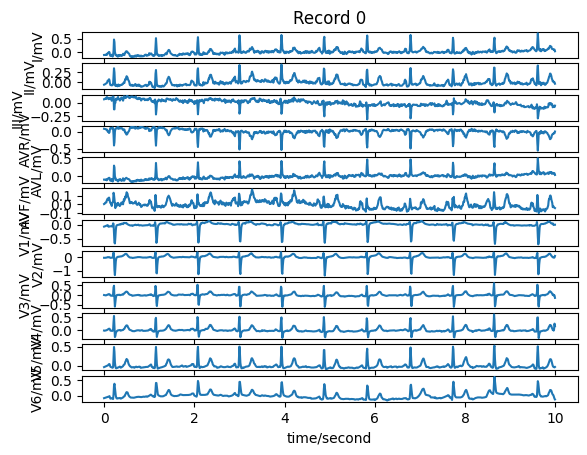

In [13]:
record0 = ecg_data[0]
wfdb.plot_wfdb(record=record0, title='Record 0')

In [81]:
test_fold = 10
x_train = ecg_data[ptbxl_filtered.strat_fold != test_fold]
y_train = ptbxl_filtered[ptbxl_filtered.strat_fold != test_fold].diagnostic_superclass

x_test = ecg_data[ptbxl_filtered.strat_fold == test_fold]
y_test = ptbxl_filtered[ptbxl_filtered.strat_fold == test_fold].diagnostic_superclass

# convert y_test and y_train from pandas.core.series.Series to numpy.ndarray of type string
y_train = y_train.astype(str).to_numpy()
y_test = y_test.astype(str).to_numpy()

print(type(y_train), type(y_test))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(19230,) (19230,)
(2158,) (2158,)


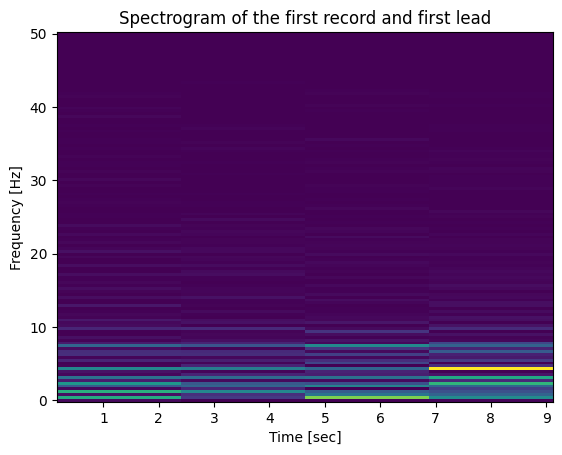

In [31]:
# find spectrogram of the first record and first lead and display it
frequencies, times, Sxx = spectrogram(x_train[0].p_signal[:, 5], fs=sampling_rate)
# print(frequencies.shape, times.shape, Sxx.shape)
# print(frequencies)
# print(times)
# print(Sxx)
# print(np.max(Sxx), np.min(Sxx))

import matplotlib.pyplot as plt
plt.pcolormesh(times, frequencies, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of the first record and first lead')
plt.show()


Sample the data using DWT

In [82]:
# TODO: Sample the data using DWT
def extract_features(signal, wavelet='db1', level=5):
    coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
    features = np.concatenate(coeffs)
    return features

In [83]:
x_train_dwt = np.array([extract_features(data.p_signal[:, 0]) for data in x_train])
x_test_dwt = np.array([extract_features(data.p_signal[:, 0]) for data in x_test])

In [84]:
x_train_dwt = x_train_dwt.reshape(x_train_dwt.shape[0], x_train_dwt.shape[1], 1)
x_test_dwt = x_test_dwt.reshape(x_test_dwt.shape[0], x_test_dwt.shape[1], 1)
print(x_train_dwt.shape, x_test_dwt.shape)
print(y_train.shape, y_test.shape)

(19230, 1002, 1) (2158, 1002, 1)
(19230,) (2158,)



Models

In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

In [89]:
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(1002, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(1002, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(1002, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [90]:
model = model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1002, 64)          448       
                                                                 
 batch_normalization_6 (Bat  (None, 1002, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 501, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 501, 64)           24640     
                                                                 
 batch_normalization_7 (Bat  (None, 501, 64)           256       
 chNormalization)                                                
                                                      

In [91]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
# s = set(y_train)

# Convert the encoded labels to categorical format
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)
# s
# Train the model
model.fit(x_train_dwt, y_train_encoded, epochs=50, batch_size=32, validation_data=(x_test_dwt, y_test_encoded))


Epoch 1/50


2024-03-23 13:20:40.729137: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-23 13:20:48.314354: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-23 13:20:48.373441: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-23 13:20:49.157926: I external/local_xla/xla/service/service.cc:168] XLA service 0x74d358305780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-23 13:20:49.157993: I external/local_xla/xla/service/service.

600/601 [============================>.] - ETA: 0s - loss: 1.2467 - accuracy: 0.5210

2024-03-23 13:21:03.565359: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-23 13:21:03.593239: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


601/601 [==============================] - 31s 19ms/step - loss: 1.2466 - accuracy: 0.5209 - val_loss: 1.3584 - val_accuracy: 0.4333
Epoch 2/50
601/601 [==============================] - 9s 15ms/step - loss: 1.1357 - accuracy: 0.5669 - val_loss: 1.1666 - val_accuracy: 0.5491
Epoch 3/50
601/601 [==============================] - 9s 15ms/step - loss: 1.1095 - accuracy: 0.5782 - val_loss: 1.2027 - val_accuracy: 0.5255
Epoch 4/50
601/601 [==============================] - 9s 15ms/step - loss: 1.0752 - accuracy: 0.5913 - val_loss: 1.3308 - val_accuracy: 0.4537
Epoch 5/50
601/601 [==============================] - 9s 15ms/step - loss: 1.0357 - accuracy: 0.6065 - val_loss: 1.1584 - val_accuracy: 0.5621
Epoch 6/50
601/601 [==============================] - 9s 15ms/step - loss: 0.9990 - accuracy: 0.6191 - val_loss: 1.2634 - val_accuracy: 0.5079
Epoch 7/50
601/601 [==============================] - 9s 15ms/step - loss: 0.9522 - accuracy: 0.6370 - val_loss: 1.2774 - val_accuracy: 0.5412
Epoch 8/5

In [94]:
_, test_acc = model.evaluate(x_test_dwt, y_test_encoded, verbose=0)
print('Test: %.3f' % (test_acc * 100))

Test: 47.220
